# Phase 1 : Data Loader Class

## Showing Sample Data

Sample annotations from gt.txt:
   frame  id    x    y    w    h  conf  class  visibility
0      1   0  463  328   89  212     1      1           1
1      1   1  262  252  125  206     1      1           1
2      1   2  695  219   74  211     1      1           1
3      1   3  565  370   93  230     1      1           1
4      1   4  777  296  106  206     1      1           1
Unique tracked objects: 10


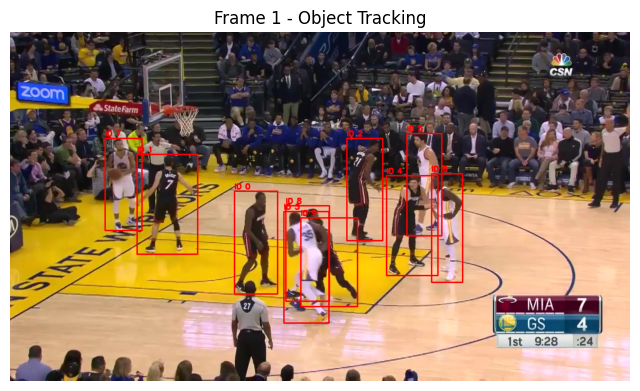

In [2]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

DATASET_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/train"

SEQUENCE_NAME = os.listdir(DATASET_PATH)[0]
SEQUENCE_PATH = os.path.join(DATASET_PATH, SEQUENCE_NAME)

GT_FILE = os.path.join(SEQUENCE_PATH, "gt", "gt.txt")
IMG_PATH = os.path.join(SEQUENCE_PATH, "img1")

columns = ["frame", "id", "x", "y", "w", "h", "conf", "class", "visibility"]
df = pd.read_csv(GT_FILE, names=columns)

print("Sample annotations from gt.txt:")
print(df.head())

print(f"Unique tracked objects: {df['id'].nunique()}")

def visualize_annotation(frame_number):
    frame_data = df[df["frame"] == frame_number]
    
    img_file = os.path.join(IMG_PATH, f"{frame_number:06d}.jpg") 
    if not os.path.exists(img_file):
        print(f"Image {img_file} not found!")
        return
    
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for _, row in frame_data.iterrows():
        x, y, w, h = int(row["x"]), int(row["y"]), int(row["w"]), int(row["h"])
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, f"ID {row['id']}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Frame {frame_number} - Object Tracking")
    plt.show()

visualize_annotation(1)

## Data Loader Class

In [3]:
from torch.utils.data import Dataset, DataLoader
class SportsMOTDataset(Dataset):
    def __init__(self, dataset_path, split="train", transform=None):
        self.dataset_path = dataset_path
        self.split = split
        self.transform = None

        self.sequence_paths = [os.path.join(dataset_path, split, seq) 
                               for seq in sorted(os.listdir(os.path.join(dataset_path, split)))]
        self.data = []

        for seq_path in self.sequence_paths:
            img_path = os.path.join(seq_path, "img1")
            gt_file = os.path.join(seq_path, "gt", "gt.txt")

            if split == "test" or not os.path.exists(gt_file):
                for img_file in sorted(os.listdir(img_path)):
                    self.data.append(os.path.join(img_path, img_file))
            else:
                
                df = pd.read_csv(gt_file, names=["frame", "id", "x", "y", "w", "h", "conf", "class", "visibility"])
                df = df.dropna()
                df = df[df["w"] > 0]
                df = df[df["h"] > 0]

                for frame_id in df["frame"].unique():
                    frame_file = os.path.join(img_path, f"{frame_id:06d}.jpg")
                    if os.path.exists(frame_file):
                        frame_annotations = df[df["frame"] == frame_id]
                        self.data.append((frame_file, frame_annotations))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index] if self.split == "test" else self.data[index][0]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.split == "test":
            return image, None, None

        # Process annotations
        frame_annotations = self.data[index][1]
        bboxes = frame_annotations[["x", "y", "w", "h"]].values.astype("float32")
        obj_ids = frame_annotations["id"].values

        bboxes = bboxes.astype("float32")

        # ٔNormalization
        img_height, img_width = image.shape[:2]
        bboxes[:, 0] = bboxes[:, 0] / float(img_width)
        bboxes[:, 1] = bboxes[:, 1] / float(img_height)
        bboxes[:, 2] = bboxes[:, 2] / float(img_width)
        bboxes[:, 3] = bboxes[:, 3] / float(img_height)

        if self.transform:
            augmented = self.transform(
                image=image,
                bboxes=bboxes.tolist(),
                class_labels=obj_ids.tolist(),
                )
            image = augmented["image"]
            bboxes = augmented["bboxes"]

        return image, torch.tensor(bboxes, dtype=torch.float32), torch.tensor(obj_ids, dtype=torch.int64)

## Data augmentation and creating train, val and test sets.

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.Resize(512, 512),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='coco', 
    label_fields=['class_labels'] 
))


dataset_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
train_dataset = SportsMOTDataset(dataset_path, split="train", transform=transform)
val_dataset = SportsMOTDataset(dataset_path, split="val", transform=transform)
test_dataset = SportsMOTDataset(dataset_path, split="test", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# Testing the DataLoader
import torch
n = 0
for images, bboxes, obj_ids in train_dataloader:
    if n >0:
        break
    print(f"Train - Batch Size: {len(images)}")
    print(f"First Image Shape: {images[0].shape}")
    print(f"Bounding Boxes: {bboxes[0]}")
    print(f"Object IDs: {obj_ids[0]}")
    n +=1

Train - Batch Size: 4
First Image Shape: (720, 1280, 3)
Bounding Boxes: tensor([[0.2344, 0.3000, 0.0203, 0.0750],
        [0.6000, 0.3028, 0.0133, 0.0722],
        [0.3992, 0.3472, 0.0148, 0.0806],
        [0.3023, 0.3778, 0.0172, 0.0861],
        [0.5586, 0.7042, 0.0203, 0.1278],
        [0.4203, 0.4639, 0.0156, 0.1069],
        [0.6250, 0.3194, 0.0141, 0.0806],
        [0.3766, 0.6889, 0.0273, 0.1278],
        [0.7312, 0.3750, 0.0141, 0.0847],
        [0.4727, 0.3431, 0.0156, 0.0833],
        [0.7672, 0.5708, 0.0305, 0.1111],
        [0.9805, 0.3278, 0.0195, 0.0889]])
Object IDs: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14])


In [6]:
print(f"train set size: {len(train_dataset)}")
print(f"val set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 28574
val set size: 26970
test set size: 94835
